## Introduction to Hidden Markov Models with Python Networkx and Sklearn


<br>Author: Rakib Al-Fahad 
<br>Phd Candidate 
<br>The University of Memphis 
<br>Memphis, Tennessee 
<br>email: ralfahad@memphis.edu 
https://rakibalfahad.github.io/


### Ref:
http://www.blackarbs.com/blog/introduction-hidden-markov-models-python-networkx-sklearn/2/9/2017

## What is the Markov Property?

"...a random process where the future is independent of the past given the present."


Assume a simplified coin toss game with a fair coin. Suspend disbelief and assume that the Markov property is not yet known and we would like to predict the probability of flipping heads after 10 flips. Under the assumption of conditional dependence (the coin has memory of past states and the future state depends on the sequence of past states) we must record the specific sequence that lead up to the 11th flip and the joint probabilities of those flips. So imagine after 10 flips we have a random sequence of heads and tails. The joint probability of that sequence is 0.5^10 = 0.0009765625. Under conditional dependence, the probability of heads on the next flip is 0.0009765625 * 0.5 = 0.00048828125. 

Is that the real probability of flipping heads on the 11th flip? Hell no!

We know that the event of flipping the coin does not depend on the result of the flip before it. The coin has no memory. The process of successive flips does not encode the prior results. Each flip is a unique event with equal probability of heads or tails, aka conditionally independent of past states. This is the Markov property.  

## What is a Markov Model?

A Markov chain (model) describes a stochastic process where the assumed probability of future state(s) depends only on the current process state and not on any the states that preceded it (shocker).

Let's get into a simple example. Assume you want to model the future probability that your dog is in one of three states given its current state. To do this <font color='red'>we need to specify the state space, the initial probabilities, and the transition probabilities.</font>

Imagine you have a very lazy fat dog, so we **define the state space as sleeping, eating, or pooping. We will set the initial probabilities to 35%, 35%, and 30% respectively.**

In [1]:
## PC config

%load_ext watermark
%watermark

2018-11-13T14:49:52

CPython 2.7.15
IPython 5.8.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.15.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 24
interpreter: 64bit


In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# create state space and initial state probabilities

states = ['sleeping', 'eating', 'pooping']
pi = [0.35, 0.35, 0.3]
state_space = pd.Series(pi, index=states, name='states')
print(state_space)
print(state_space.sum())

sleeping    0.35
eating      0.35
pooping     0.30
Name: states, dtype: float64
1.0


The next step is to **define the transition probabilities**. They are simply the probabilities of staying in the same state or moving to a different state given the current state. 

In [3]:
# create transition matrix
# equals transition probability matrix of changing states given a state
# matrix is size (M x M) where M is number of states

q_df = pd.DataFrame(columns=states, index=states)
q_df.loc[states[0]] = [0.4, 0.2, 0.4]
q_df.loc[states[1]] = [0.45, 0.45, 0.1]
q_df.loc[states[2]] = [0.45, 0.25, .3]

q = q_df.values
print('\n', q, q.shape, '\n')
print(q_df.sum(axis=1))

q_df

('\n', array([[0.4, 0.2, 0.4],
       [0.45, 0.45, 0.1],
       [0.45, 0.25, 0.3]], dtype=object), (3, 3), '\n')
sleeping    1.0
eating      1.0
pooping     1.0
dtype: float64


,sleeping,eating,pooping
sleeping,0.4,0.2,0.4
eating,0.45,0.45,0.1
pooping,0.45,0.25,0.3


Now that we have the initial and transition probabilities setup we can create a **Markov diagram using the Networkx package.**

To do this requires a little bit of flexible thinking. Networkx creates Graphs that consist of nodes and edges. In our toy example the dog's possible states are the nodes and the edges are the lines that connect the nodes. The transition probabilities are the weights. They represent the probability of transitioning to a state given the current state.

Something to note is networkx deals primarily with dictionary objects. With that said, we need to create a dictionary object that holds our edges and their weights.

In [4]:
from pprint import pprint 

# create a function that maps transition probability dataframe 
# to markov edges and weights

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(q_df)
pprint(edges_wts)

{('eating', 'eating'): 0.45,
 ('eating', 'pooping'): 0.1,
 ('eating', 'sleeping'): 0.45,
 ('pooping', 'eating'): 0.25,
 ('pooping', 'pooping'): 0.3,
 ('pooping', 'sleeping'): 0.45,
 ('sleeping', 'eating'): 0.2,
 ('sleeping', 'pooping'): 0.4,
 ('sleeping', 'sleeping'): 0.4}


## You will need pydot

To install this package with conda run:
 "conda install -c anaconda pydot"

OutMultiEdgeDataView([('eating', 'eating', {'weight': 0.45, 'label': 0.45}), ('eating', 'pooping', {'weight': 0.1, 'label': 0.1}), ('eating', 'sleeping', {'weight': 0.45, 'label': 0.45}), ('pooping', 'eating', {'weight': 0.25, 'label': 0.25}), ('pooping', 'pooping', {'weight': 0.3, 'label': 0.3}), ('pooping', 'sleeping', {'weight': 0.45, 'label': 0.45}), ('sleeping', 'eating', {'weight': 0.2, 'label': 0.2}), ('sleeping', 'pooping', {'weight': 0.4, 'label': 0.4}), ('sleeping', 'sleeping', {'weight': 0.4, 'label': 0.4})])


,sleeping,eating,pooping
sleeping,0.4,0.2,0.4
eating,0.45,0.45,0.1
pooping,0.45,0.25,0.3


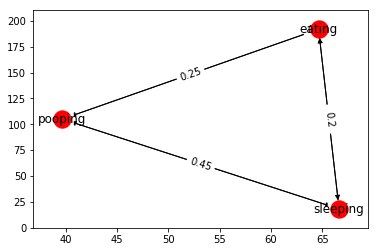

In [5]:
# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(states)
#print(r'Nodes:\n{G.nodes()}\n')

# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
#print('Edges:')
pprint(G.edges(data=True))    

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_markov.dot')

q_df

## Graphviz visualization

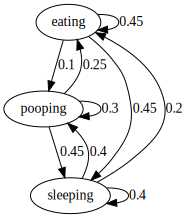

In [6]:
import graphviz

with open("pet_dog_markov.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

## What Makes a Markov Model Hidden?
Consider a situation where your dog is acting strangely and **you wanted to model the probability that your dog's behavior is due to sickness or simply quirky behavior when otherwise healthy.**

In this situation the true state of the dog is unknown, thus hidden from you. One way to model this is to assume that the dog has observable behaviors that represent the true, hidden state. Let's walk through an example.

***First we create our state space - healthy or sick. We assume they are equiprobable.***  

In [7]:
# create state space and initial state probabilities

hidden_states = ['healthy', 'sick']
pi = [0.5, 0.5]
state_space = pd.Series(pi, index=hidden_states, name='states')
print(state_space)
print(state_space.sum())

healthy    0.5
sick       0.5
Name: states, dtype: float64
1.0


## We create our transition matrix for the hidden states.

In [8]:
# create hidden transition matrix
# a or alpha 
#   = transition probability matrix of changing states given a state
# matrix is size (M x M) where M is number of states

a_df = pd.DataFrame(columns=hidden_states, index=hidden_states)
a_df.loc[hidden_states[0]] = [0.7, 0.3]
a_df.loc[hidden_states[1]] = [0.4, 0.6]

a_df

# a = a_df.values

# print(a, a.shape, '\n')
# print(a_df.sum(axis=1))

,healthy,sick
healthy,0.7,0.3
sick,0.4,0.6


This is where it gets a little more interesting. Now we create the **emission or observation probability matrix. This matrix is size M x O where M is the number of hidden states and O is the number of possible observable states.** 

The emission matrix tells us the probability the dog is in one of the hidden states, given the current, observable state. 

Let's keep the same observable states from the previous example. The dog can be either sleeping, eating, or pooping. For now we make our best guess to fill in the probabilities. from mpl_finance import quotes_historical_yahoo

In [10]:
# create matrix of observation (emission) probabilities
# b or beta = observation probabilities given state
# matrix is size (M x O) where M is number of states 
# and O is number of different possible observations

observable_states = states

b_df = pd.DataFrame(columns=observable_states, index=hidden_states)
b_df.loc[hidden_states[0]] = [0.2, 0.6, 0.2]
b_df.loc[hidden_states[1]] = [0.4, 0.1, 0.5]

b_df


,sleeping,eating,pooping
healthy,0.2,0.6,0.2
sick,0.4,0.1,0.5


Now we create the graph edges and the graph object. 

In [11]:
# create graph edges and weights

hide_edges_wts = _get_markov_edges(a_df)
pprint(hide_edges_wts)

emit_edges_wts = _get_markov_edges(b_df)
pprint(emit_edges_wts)

{('healthy', 'healthy'): 0.7,
 ('healthy', 'sick'): 0.3,
 ('sick', 'healthy'): 0.4,
 ('sick', 'sick'): 0.6}
{('healthy', 'eating'): 0.6,
 ('healthy', 'pooping'): 0.2,
 ('healthy', 'sleeping'): 0.2,
 ('sick', 'eating'): 0.1,
 ('sick', 'pooping'): 0.5,
 ('sick', 'sleeping'): 0.4}


OutMultiEdgeDataView([('healthy', 'healthy', {'weight': 0.7, 'label': 0.7}), ('healthy', 'eating', {'weight': 0.6, 'label': 0.6}), ('healthy', 'pooping', {'weight': 0.2, 'label': 0.2}), ('healthy', 'sick', {'weight': 0.3, 'label': 0.3}), ('healthy', 'sleeping', {'weight': 0.2, 'label': 0.2}), ('sick', 'healthy', {'weight': 0.4, 'label': 0.4}), ('sick', 'eating', {'weight': 0.1, 'label': 0.1}), ('sick', 'pooping', {'weight': 0.5, 'label': 0.5}), ('sick', 'sick', {'weight': 0.6, 'label': 0.6}), ('sick', 'sleeping', {'weight': 0.4, 'label': 0.4})])


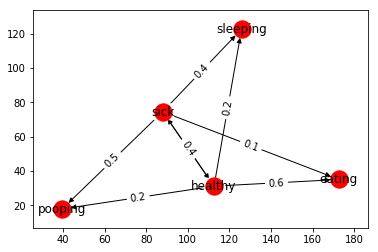

In [13]:
# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(hidden_states)
#print(f'Nodes:\n{G.nodes()}\n')

# edges represent hidden probabilities
for k, v in hide_edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

# edges represent emission probabilities
for k, v in emit_edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
    
#print(f'Edges:')
pprint(G.edges(data=True))    

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='neato')
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
emit_edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=emit_edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_hidden_markov.dot')

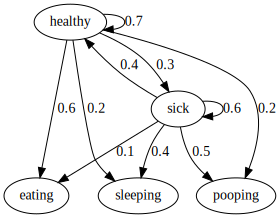

In [14]:

with open("pet_dog_hidden_markov.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

The hidden Markov graph is a little more complex but the principles are the same. For example, you would expect that if your dog is eating there is a high probability that it is healthy (60%) and a very low probability that the dog is sick (10%).

Now, what if you needed to discern the health of your dog over time given a sequence of observations?  

In [15]:
# observation sequence of dog's behaviors
# observations are encoded numerically

obs_map = {'sleeping':0, 'eating':1, 'pooping':2}
obs = np.array([1,1,2,1,0,1,2,1,0,2,2,0,1,0,1])

inv_obs_map = dict((v,k) for k, v in obs_map.items())
obs_seq = [inv_obs_map[v] for v in list(obs)]

print( pd.DataFrame(np.column_stack([obs, obs_seq]), 
                columns=['Obs_code', 'Obs_seq']) )

   Obs_code   Obs_seq
0         1    eating
1         1    eating
2         2   pooping
3         1    eating
4         0  sleeping
5         1    eating
6         2   pooping
7         1    eating
8         0  sleeping
9         2   pooping
10        2   pooping
11        0  sleeping
12        1    eating
13        0  sleeping
14        1    eating


Using the **Viterbi algorithm** we can identify the most likely sequence of hidden states given the sequence of observations.

High level, the Viterbi algorithm increments over each time step, finding the maximum probability of any path that gets to state iat time t, that also has the correct observations for the sequence up to time t.

The algorithm also keeps track of the state with the highest probability at each stage. At the end of the sequence, the algorithm will iterate backwards selecting the state that "won" each time step, and thus creating the most likely path, or likely sequence of hidden states that led to the sequence of observations.

In [16]:
# define Viterbi algorithm for shortest path
# code adapted from Stephen Marsland's, Machine Learning An Algorthmic Perspective, Vol. 2
# https://github.com/alexsosn/MarslandMLAlgo/blob/master/Ch16/HMM.py

def viterbi(pi, a, b, obs):
    
    nStates = np.shape(b)[0]
    T = np.shape(obs)[0]
    
    # init blank path
    path = np.zeros(T)
    # delta --> highest probability of any path that reaches state i
    delta = np.zeros((nStates, T))
    # phi --> argmax by time step for each state
    phi = np.zeros((nStates, T))
    
    # init delta and phi 
    delta[:, 0] = pi * b[:, obs[0]]
    phi[:, 0] = 0

    print('Start Walk Forward \n')    
    # the forward algorithm extension
    for t in range(1, T):
        for s in range(nStates):
            delta[s, t] = np.max(delta[:, t-1] * a[:, s]) * b[s, obs[t]] 
            phi[s, t] = np.argmax(delta[:, t-1] * a[:, s])
            print('s={s} and t={t}: phi[{s}, {t}] = {phi}'.format(s=s, t=t, phi=phi[s, t]))
    
    # find optimal path
    print('-'*50)
    print('Start Backtrace\n')
    path[T-1] = np.argmax(delta[:, T-1])
    #p('init path\n    t={} path[{}-1]={}\n'.format(T-1, T, path[T-1]))
    for t in range(T-2, -1, -1):
        path[t] = phi[path[t+1], [t+1]]
        #p(' '*4 + 't={t}, path[{t}+1]={path}, [{t}+1]={i}'.format(t=t, path=path[t+1], i=[t+1]))
        print('path[{}] = {}'.format(t, path[t]))
        
    return path, delta, phi

path, delta, phi = viterbi(pi, a, b, obs)
print('\nsingle best state path: \n', path)
print('delta:\n', delta)
print('phi:\n', phi)

NameError: name 'a' is not defined

In [17]:
import numpy as np
from sklearn import hmm

startprob = np.array([0.6, 0.3, 0.1])
transmat = np.array([[0.7, 0.2, 0.1], [0.3, 0.5, 0.2], [0.3, 0.3, 0.4]])
#means = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
#covars = np.tile(np.identity(2), (3, 1, 1))
model = hmm.GaussianHMM(3, "full", startprob, transmat)
model.means_ = means
model.covars_ = covars
X, Z = model.sample(100)

ImportError: cannot import name hmm